In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:22<00:00, 108MB/s]
100% 1.76G/1.76G [00:22<00:00, 84.0MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import os

In [ ]:
train_augs = T.Compose([
    T.Resize((256, 256)),  # Reduce computational load
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_augs = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# Get the data
IMAGES_PATH = "/content/dataset/lung_colon_image_set/lung_image_sets"

dataset = ImageFolder(root=IMAGES_PATH, transform=None)

In [ ]:
# Define the training dataset and the validation dataset
trainset, validset = random_split(dataset, [10000, 5000])

trainset.dataset.transform = train_augs; validset.dataset.transform = valid_augs

In [ ]:
# Define Hyperparamters
BATCH_SIZE = 32
BETAS = (0.9, 0.999)
LR = 3e-4
EPOCHS = 30
DEVICE = "cuda"

In [ ]:
# Define a loader for the training and validation data
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Get the diminsions of the images
images, labels = next(iter(trainloader))

images.shape

torch.Size([32, 3, 256, 256])

In [ ]:
label_to_class = {idx: class_name for idx, class_name in enumerate(dataset.classes)}

label_to_class

{0: 'lung_aca', 1: 'lung_n', 2: 'lung_scc'}

In [ ]:
# Show images in the dataloader
def show_imgs(dataloader: DataLoader) -> None:
    for images, labels in dataloader:
        f, axarr = plt.subplots(8, 4)
        idx = 0
        for row in range(8):
            for col in range(4):
                image = images[idx].permute(1, 2, 0).numpy()
                label = labels[idx]

                axarr[row, col].imshow(image)
                axarr[row, col].set_title(label_to_class[int(label)])
                idx += 1
        plt.show()

        break

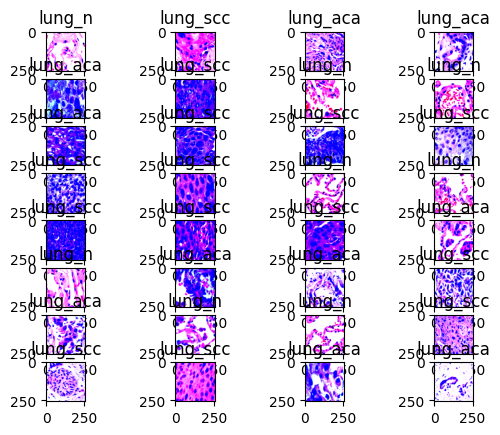

In [ ]:
# Show images of the trainloader
show_imgs(trainloader)

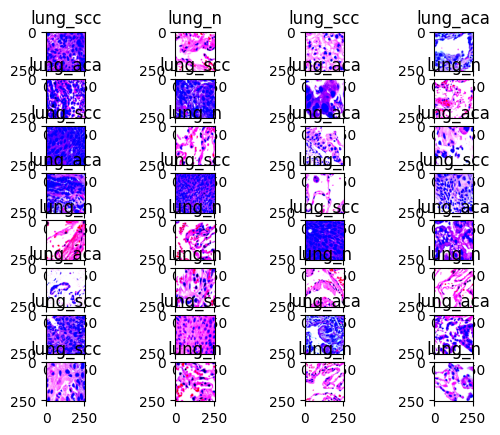

In [ ]:
# Show images of the validloader
show_imgs(validloader)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),

            nn.AdaptiveAvgPool2d((6, 6))
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity='relu')
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

In [ ]:
model = Net().to(DEVICE)

In [ ]:
# Now we need to define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LR, betas=BETAS)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

In [ ]:
def train(epochs, criterion, optimizer, scheduler=None):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate(model, validloader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if scheduler:
            scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
            print(f"New best model saved with Val Acc: {val_acc:.2f}%")

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [ ]:
def validate(model, validloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in validloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track validation metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_loss = running_loss / len(validloader)
    val_acc = 100 * correct_val / total_val

    return val_loss, val_acc

Epoch [1/30], Batch [10/313], Loss: 0.1273
Epoch [1/30], Batch [20/313], Loss: 0.1159
Epoch [1/30], Batch [30/313], Loss: 0.1611
Epoch [1/30], Batch [40/313], Loss: 0.1371
Epoch [1/30], Batch [50/313], Loss: 0.0834
Epoch [1/30], Batch [60/313], Loss: 0.0697
Epoch [1/30], Batch [70/313], Loss: 0.3797
Epoch [1/30], Batch [80/313], Loss: 0.5470
Epoch [1/30], Batch [90/313], Loss: 0.3045
Epoch [1/30], Batch [100/313], Loss: 0.2683
Epoch [1/30], Batch [110/313], Loss: 0.2566
Epoch [1/30], Batch [120/313], Loss: 0.2834
Epoch [1/30], Batch [130/313], Loss: 0.2732
Epoch [1/30], Batch [140/313], Loss: 0.0266
Epoch [1/30], Batch [150/313], Loss: 0.1394
Epoch [1/30], Batch [160/313], Loss: 0.2384
Epoch [1/30], Batch [170/313], Loss: 0.2265
Epoch [1/30], Batch [180/313], Loss: 0.1987
Epoch [1/30], Batch [190/313], Loss: 0.1831
Epoch [1/30], Batch [200/313], Loss: 0.1594
Epoch [1/30], Batch [210/313], Loss: 0.0845
Epoch [1/30], Batch [220/313], Loss: 0.0555
Epoch [1/30], Batch [230/313], Loss: 0.10

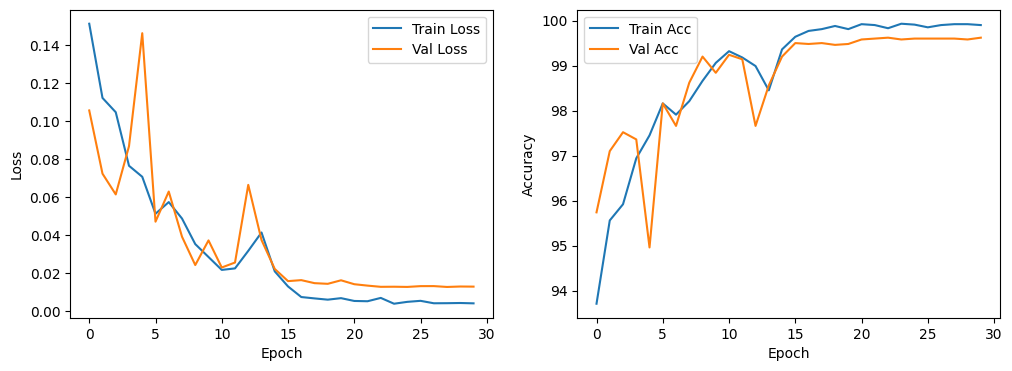

In [24]:
train(EPOCHS, criterion, optimizer, scheduler)

In [ ]:
new_model = Net()
new_model.load_state_dict(torch.load('../models/best_model_epoch_16.pth'))

validate(new_model, validloader, criterion)

<ipython-input-32-a315182ea589>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./checkpoints/best_model_epoch_6.pth'))


Validation Loss: 0.0525, Validation Accuracy: 98.04%


0.05252229281112397